In [2]:
import pandas as pd
df=pd.read_csv('data.csv')

In [3]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nandiniupadhyay/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nandiniupadhyay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nandiniupadhyay/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
titles=df['title'].tolist()
cleaned_titles=[]
# Define the lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

# Preprocessing function
for text in titles:
    # Lowercase the text
    text = text.lower()
    
    # Remove punctuation and special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
      
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords and lemmatize each word
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    # Join tokens back into a single string
    preprocessed_text = " ".join(tokens)
    
    cleaned_titles.append(preprocessed_text)

# Apply preprocessing to each title in the list

# Add the cleaned titles back to the DataFrame
df['cleaned_title'] = cleaned_titles

# Display the DataFrame
df.head()

,ticker,date,time,title,cleaned_title
0,AMZN,Oct-29-24,12:44PM,Ray Wang on Amazon.com Inc (NASDAQ:AMZN): Stro...,ray wang amazoncom inc nasdaqamzn strong funda...
1,AMZN,Oct-29-24,12:06PM,Duck Capital calls for 'significant' capital r...,duck capital call significant capital return a...
2,AMZN,Oct-29-24,12:00PM,Is an earnings beat enough for Big Tech invest...,earnings beat enough big tech investor
3,AMZN,Oct-29-24,11:37AM,Amazon pilots 'Rufus' generative AI shopping a...,amazon pilot rufus generative ai shopping assi...
4,AMZN,Oct-29-24,11:16AM,"Do Amazon, Alphabet, and Apple Have an AI Spen...",amazon alphabet apple ai spending problem mean...


In [5]:
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet
nltk.download('sentiwordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package sentiwordnet to
[nltk_data]     /Users/nandiniupadhyay/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/nandiniupadhyay/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [6]:
def get_wordnet_pos(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
lemmatizer = WordNetLemmatizer()

X_tfidf = vectorizer.fit_transform(df['title'])
tfidf_feature_names = vectorizer.get_feature_names_out()

In [8]:
def calculate_weighted_sentiment_score(text, tfidf_vector):
    tokens = word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    weighted_score = 0

    for idx, (word, tag) in enumerate(pos_tags):
        # Get WordNet POS tag and lemmatize the word
        wn_tag = get_wordnet_pos(tag)
        if wn_tag:  # Only proceed if POS tag is recognized
            lemma = lemmatizer.lemmatize(word, pos=wn_tag)

            # Get SentiWordNet scores
            synsets = list(swn.senti_synsets(lemma, wn_tag))
            if synsets:
                # Take the first synset as the representative score
                synset = synsets[0]
                sentiment_score = synset.pos_score() - synset.neg_score()

                # Check if word exists in the TF-IDF feature names
                if word in tfidf_feature_names:
                    tfidf_index = tfidf_feature_names.tolist().index(word)
                    tfidf_value = tfidf_vector[tfidf_index]

                    # Multiply sentiment score by TF-IDF weight
                    weighted_score += sentiment_score * tfidf_value

    return weighted_score

# Step 3: Apply the weighted sentiment score calculation for each title
weighted_scores = []
for i, title in enumerate(df['title']):
    tfidf_vector = X_tfidf[i].toarray().flatten()
    weighted_score = calculate_weighted_sentiment_score(title, tfidf_vector)
    weighted_scores.append(weighted_score)

# Add weighted scores to DataFrame
df['weighted_sentiment_score'] = weighted_scores

# Step 4: Assign labels based on the weighted sentiment score
def assign_sentiment_label(score):
    if score >= 0:
        return 'positive'
    else:
        return 'negative'
    

df['sentiment_label'] = df['weighted_sentiment_score'].apply(assign_sentiment_label)

# Display the DataFrame with scores and labels
print(df[['title', 'weighted_sentiment_score', 'sentiment_label']])

                                                 title  \
0    Ray Wang on Amazon.com Inc (NASDAQ:AMZN): Stro...   
1    Duck Capital calls for 'significant' capital r...   
2    Is an earnings beat enough for Big Tech invest...   
3    Amazon pilots 'Rufus' generative AI shopping a...   
4    Do Amazon, Alphabet, and Apple Have an AI Spen...   
..                                                 ...   
495  Microsoft Corporation (MSFT) Gave Back Some of...   
496  Tesla's Stock Taps the Brakes, But It's Still ...   
497  Betting on Bitcoin? Microsoft's shareholders w...   
498  Colgate-Palmolive, Centene, Microsoft: 3 stock...   
499  Microsoft CEO Satya Nadella asked for a pay cu...   

     weighted_sentiment_score sentiment_label  
0                    0.000000        positive  
1                    0.073346        positive  
2                    0.058731        positive  
3                    0.000000        positive  
4                    0.000000        positive  
..             

In [9]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# Ensure that VADER lexicon is downloaded
nltk.download('vader_lexicon')

# Initialize VADER Sentiment Intensity Analyzer
sia = SentimentIntensityAnalyzer()

# Function to assign sentiment labels
def assign_sentiment(text):
    score = sia.polarity_scores(text)['compound']
    if score >=0:
        return 'positive'
    else:
        return 'negative'
   
    

# Apply the function to the 'cleaned_title' column
df['label'] = df['cleaned_title'].apply(assign_sentiment)

# Display the DataFrame with sentiment labels
print(df[['cleaned_title', 'label']])


                                         cleaned_title     label
0    ray wang amazoncom inc nasdaqamzn strong funda...  positive
1    duck capital call significant capital return a...  positive
2               earnings beat enough big tech investor  positive
3    amazon pilot rufus generative ai shopping assi...  positive
4    amazon alphabet apple ai spending problem mean...  negative
..                                                 ...       ...
495  microsoft corporation msft gave back first hal...  positive
496  tesla stock tap brake still rising magnificent...  positive
497  betting bitcoin microsofts shareholder decide ...  positive
498     colgatepalmolive centene microsoft stock focus  positive
499  microsoft ceo satya nadella asked pay cut stil...  negative

[500 rows x 2 columns]


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/nandiniupadhyay/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [10]:
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(df['label'], df['sentiment_label']))

Accuracy: 0.886


In [13]:
from sklearn.metrics import classification_report
print("Classification Report:\n", classification_report(df['label'], df['sentiment_label']))

Classification Report:
               precision    recall  f1-score   support

    negative       0.42      0.21      0.28        53
    positive       0.91      0.97      0.94       447

    accuracy                           0.89       500
   macro avg       0.67      0.59      0.61       500
weighted avg       0.86      0.89      0.87       500



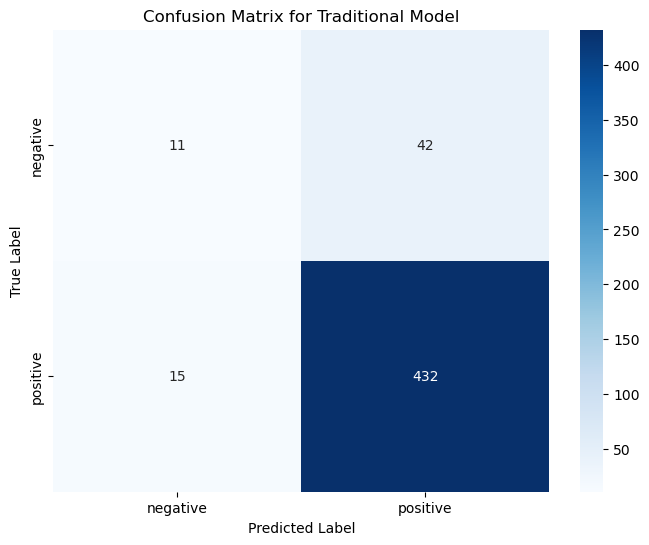

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_pred_cnn_labels contains the predicted labels from the CNN model
# and y_test contains the true labels


# Generate the confusion matrix
conf_matrix = confusion_matrix(df['label'], df['sentiment_label'])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'positive'], yticklabels=['negative', 'positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Traditional Model')
plt.show()